In [ ]:
%pip install datasets evaluate transformers ipympl --quiet
%pip install transformers[torch] --quiet
%pip install sentencepiece --quiet

In [1]:
import os

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from datasets import DatasetDict, load_dataset, concatenate_datasets
from transformers import (
    AutoModel,
    AutoTokenizer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    Trainer,
    TrainingArguments,
)

In [2]:
INPUT_DIR = "."
OUTPUT_DIR = "./output/bert"
CHECKPOINT = "google-bert/bert-base-multilingual-uncased"
CACHE_DIR = "./models"

In [3]:
# Load data
data = load_dataset(
    "csv",
    data_files=os.path.join(INPUT_DIR, "train.csv"),
    trust_remote_code=True,
    split="train",
)
data = data.train_test_split(0.2)

aug_data = load_dataset(
    "csv",
    data_files=os.path.join(INPUT_DIR, "translated.csv"),
    trust_remote_code=True,
    split="train",
)

train_data_with_aug = concatenate_datasets([data["train"], aug_data])
shuffled_dataset = train_data_with_aug.shuffle(seed=42)

data = DatasetDict(
    {
        "train": shuffled_dataset,
        "val": data["test"],
        "test": load_dataset(
            "csv",
            data_files=os.path.join(INPUT_DIR, "test.csv"),
            trust_remote_code=True,
            split="train",
        ),
    }
)


In [4]:
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT, truncation=True, cache_dir=CACHE_DIR)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
def preprocess_data(batch):
    return tokenizer(batch['premise'], batch['hypothesis'], truncation=True, padding=True)


data = data.map(preprocess_data, batched=True)

Map:   0%|          | 0/105876 [00:00<?, ? examples/s]

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

In [22]:
class BERTEmbCNN(nn.Module):
    def __init__(self, checkpoint, num_labels, cache_dir):
        super(BERTEmbCNN, self).__init__()
        self.bert_emb = AutoModel.from_pretrained(checkpoint, cache_dir=cache_dir).embeddings
        self.num_labels = num_labels
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=768, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=768, out_channels=512, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256, num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        embeddings = self.bert_emb(input_ids).transpose(1, 2)
        x = self.conv1(embeddings)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = torch.max(x, dim=2).values
        logits = self.fc(x)

        output = {'logits': logits}
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            output['loss'] = loss

        return output


class BERTEmbLSTM(nn.Module):
    def __init__(self, checkpoint, num_labels, cache_dir):
        super(BERTEmbLSTM, self).__init__()
        self.num_labels = num_labels
        self.bert_emb = AutoModel.from_pretrained(checkpoint, cache_dir=cache_dir).embeddings
        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=256,
            num_layers=1,
            batch_first=True 
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        embeddings = self.bert_emb(input_ids)
        output, (h_n, c_n) = self.lstm(embeddings)
        last_output = output[:, -1, :]
        x = self.relu(last_output)
        x = self.dropout(x)
        logits = self.fc(x)
        
        output = {'logits': logits}
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            output['loss'] = loss

        return output


class BERTEmbGRU(nn.Module):
    def __init__(self, checkpoint, num_labels, cache_dir):
        super(BERTEmbGRU, self).__init__()
        self.num_labels = num_labels
        self.bert_emb = AutoModel.from_pretrained(checkpoint, cache_dir=cache_dir).embeddings
        self.gru = nn.GRU(
            input_size=768, 
            hidden_size=512, 
            num_layers=1, 
            batch_first=True
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(512, num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        embeddings = self.bert_emb(input_ids)
        output, h_n = self.gru(embeddings)  # h_n: (num_layers, batch_size, hidden_size)
        x = output[:, -1, :]
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.fc(x)

        output = {'logits': logits}
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            output['loss'] = loss

        return output


class BERTEmbRNN(nn.Module):
    def __init__(self, checkpoint, num_labels, cache_dir):
        super(BERTEmbRNN, self).__init__()
        self.num_labels = num_labels
        self.bert_emb = AutoModel.from_pretrained(checkpoint, cache_dir=cache_dir).embeddings
        self.rnn = nn.RNN(
            input_size=768, hidden_size=256, num_layers=1, batch_first=True
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, input_ids, attention_mask=None, labels=None):
        embeddings = self.bert_emb(input_ids)
        # RNN的输出包括 (output, h_n)
        output, h_n = self.rnn(embeddings)  # output: (batch_size, seq_length, hidden_size)
        x = output[:, -1, :] 
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.fc(x)

        output = {'logits': logits}
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            output['loss'] = loss

        return output
    
model = BERTEmbRNN(CHECKPOINT, num_labels=3, cache_dir=CACHE_DIR)

/usr/local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [23]:
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=labels)

train_args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, "results"),
    logging_dir=os.path.join(OUTPUT_DIR, "logs"),
    report_to=[],
    evaluation_strategy="steps",
    eval_steps=2000,
    logging_steps=2000,
    save_steps=2000,
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.005,
    num_train_epochs=5,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=3,
    save_only_model=True,
)

In [24]:
trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=data["train"],
    eval_dataset=data["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(3)],
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
2000,1.104300,1.101039,0.333746
4000,1.102000,1.099810,0.333746
6000,1.100800,1.101921,0.350660
8000,1.101000,1.099866,0.336634
10000,1.100900,1.101403,0.348597
12000,1.099500,1.101492,0.334158


TrainOutput(global_step=12000, training_loss=1.1014329833984375, metrics={'train_runtime': 218.7933, 'train_samples_per_second': 2419.544, 'train_steps_per_second': 151.239, 'total_flos': 0.0, 'train_loss': 1.1014329833984375, 'epoch': 1.8132366273798732})

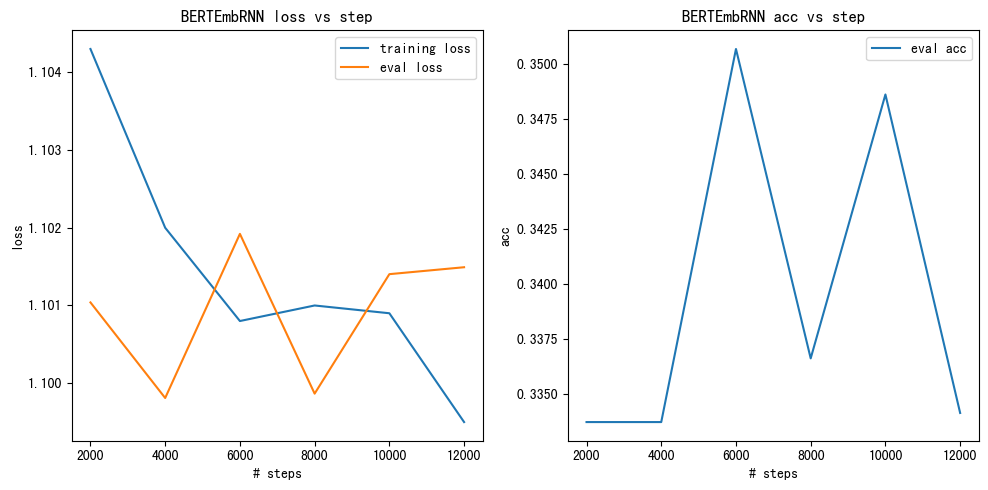

In [25]:
log = trainer.state.log_history

steps = []
train_loss = []
eval_loss = []
eval_acc = []

for i in range(0, len(log) - 1, 2):
    train_log = log[i]
    eval_log = log[i + 1]
    steps.append(train_log["step"])
    train_loss.append(train_log["loss"])
    eval_loss.append(eval_log["eval_loss"])
    eval_acc.append(eval_log["eval_accuracy"])

plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.title("BERTEmbRNN loss vs step")
plt.xlabel("# steps")
plt.ylabel("loss")
plt.plot(steps, train_loss, label="training loss")
plt.plot(steps, eval_loss, label="eval loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("BERTEmbRNN acc vs step")
plt.xlabel("# steps")
plt.ylabel("acc")
plt.plot(steps, eval_acc, label="eval acc")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
preds = trainer.predict(data["test"])

In [ ]:
pd.DataFrame(
    {"id": data["test"]["id"], "prediction": np.argmax(preds.predictions, axis=1)}
).to_csv(os.path.join(OUTPUT_DIR, "submission.csv"), header=True, index=False)